In [10]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random
import matplotlib.pyplot as plt
import pprint
import pandas as pd

import highway_env

In [11]:
# --- HYPERPARAMETERS ---
NUM_EPISODES       = 1500
MAX_STEPS_PER_EP   = 200
BATCH_SIZE         = 64
BUFFER_SIZE        = 50_000
GAMMA              = 0.99
EPS_START, EPS_END = 1.0, 0.01
EPS_DECAY          = 0.99
TARGET_UPD_FREQ    = 1_000      # steps
LR                 = 5e-4

# --- BASE CONFIG & VARIANTS ---
BASE_CONFIG = {
    "observation":       {"type": "Kinematics"},
    "action":            {"type": "DiscreteMetaAction"},
    "lanes_count":       4,
    "vehicles_count":    50,
    "controlled_vehicles": 1,
    "duration":          40,
    "ego_spacing":       2,
    "vehicles_density":  1,
    "collision_reward":  -1,
    "right_lane_reward": 0.1,
    "high_speed_reward": 0.4,        # keep constant
    "lane_change_reward": 0,
    "normalize_reward":  True,
    "offroad_terminal":  False,
}

SCENARIOS = {
    "Slow":   {"reward_speed_range": [10, 20]},
    "Normal": {"reward_speed_range": [20, 30]},
    "Fast":   {"reward_speed_range": [30, 40]},
}

In [12]:
def create_q_model(input_shape, num_actions):
    """Simple MLP Q-network."""
    return tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_actions, activation="linear"),
    ])


def train_on_env(env_config, label):
    """Train a fresh DQN, recording per‐episode total rewards."""
    # 1) build env
    cfg = BASE_CONFIG.copy()
    cfg.update(env_config)
    env = gym.make("highway-v0", render_mode="rgb_array", config=cfg)
    obs_shape   = env.observation_space.shape
    num_actions = env.action_space.n

    # 2) networks, buffer, optimizer
    q_model  = create_q_model(obs_shape, num_actions)
    q_target = create_q_model(obs_shape, num_actions)
    q_target.set_weights(q_model.get_weights())
    buffer   = deque(maxlen=BUFFER_SIZE)
    optimizer = tf.keras.optimizers.Adam(LR)
    loss_fn   = tf.keras.losses.MeanSquaredError()

    epsilon    = EPS_START
    step_count = 0
    episode_rewards = []  # <-- track total reward per episode

    # 3) training loop
    for ep in range(1, NUM_EPISODES + 1):
        state, _ = env.reset(seed=ep)
        total_reward = 0.0

        for t in range(MAX_STEPS_PER_EP):
            # ε-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_vals = q_model.predict(state[np.newaxis], verbose=0)[0]
                action = int(np.argmax(q_vals))

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            buffer.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            step_count += 1

            # learning update
            if len(buffer) >= BATCH_SIZE:
                batch = random.sample(buffer, BATCH_SIZE)
                S  = np.array([b[0] for b in batch])
                A  = np.array([b[1] for b in batch])
                R  = np.array([b[2] for b in batch], dtype=float)
                S2 = np.array([b[3] for b in batch])
                D  = np.array([b[4] for b in batch], dtype=float)

                q_next = q_target.predict(S2, verbose=0)
                max_q  = np.max(q_next, axis=1)
                y      = R + (1 - D) * GAMMA * max_q

                with tf.GradientTape() as tape:
                    q_pred = q_model(S)
                    q_sel  = tf.reduce_sum(q_pred * tf.one_hot(A, num_actions), axis=1)
                    loss   = loss_fn(y, q_sel)
                grads = tape.gradient(loss, q_model.trainable_variables)
                optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

            # periodically sync target network
            if step_count % TARGET_UPD_FREQ == 0:
                q_target.set_weights(q_model.get_weights())

            if done:
                break

        # record episode reward and decay ε
        episode_rewards.append(total_reward)
        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        if ep % 10 == 0:
            print(f"[{label}] Episode {ep}/{NUM_EPISODES} — Reward: {total_reward:.1f}, ε: {epsilon:.3f}")

    return env, q_model, episode_rewards

In [13]:
pprint.pprint(SCENARIOS)
episode_dict = dict()
trained = {}
for label, env_cfg in SCENARIOS.items():
    print("\n" + "="*40)
    print(f" Training scenario ▶️ {label}")
    print("="*40)
    env, q_model, episode_rewards= train_on_env(env_cfg, label)
    episode_dict[label] = episode_rewards
    trained[label] = (env, q_model)

{'Fast': {'reward_speed_range': [30, 40]},
 'Normal': {'reward_speed_range': [20, 30]},
 'Slow': {'reward_speed_range': [10, 20]}}

 Training scenario ▶️ Slow


/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Slow] Episode 10/1500 — Reward: 38.8, ε: 0.904
[Slow] Episode 20/1500 — Reward: 15.0, ε: 0.818
[Slow] Episode 30/1500 — Reward: 4.8, ε: 0.740
[Slow] Episode 40/1500 — Reward: 3.0, ε: 0.669
[Slow] Episode 50/1500 — Reward: 10.9, ε: 0.605
[Slow] Episode 60/1500 — Reward: 11.6, ε: 0.547
[Slow] Episode 70/1500 — Reward: 17.2, ε: 0.495
[Slow] Episode 80/1500 — Reward: 39.5, ε: 0.448
[Slow] Episode 90/1500 — Reward: 39.8, ε: 0.405
[Slow] Episode 100/1500 — Reward: 27.2, ε: 0.366
[Slow] Episode 110/1500 — Reward: 39.1, ε: 0.331
[Slow] Episode 120/1500 — Reward: 39.9, ε: 0.299
[Slow] Episode 130/1500 — Reward: 4.0, ε: 0.271
[Slow] Episode 140/1500 — Reward: 40.0, ε: 0.245
[Slow] Episode 150/1500 — Reward: 14.2, ε: 0.221
[Slow] Episode 160/1500 — Reward: 37.9, ε: 0.200
[Slow] Episode 170/1500 — Reward: 37.0, ε: 0.181
[Slow] Episode 180/1500 — Reward: 37.3, ε: 0.164
[Slow] Episode 190/1500 — Reward: 39.4, ε: 0.148
[Slow] Episode 200/1500 — Reward: 37.4, ε: 0.134
[Slow] Episode 210/1500 — Reward

/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Normal] Episode 10/1500 — Reward: 6.4, ε: 0.904
[Normal] Episode 20/1500 — Reward: 2.6, ε: 0.818
[Normal] Episode 30/1500 — Reward: 2.3, ε: 0.740
[Normal] Episode 40/1500 — Reward: 19.9, ε: 0.669
[Normal] Episode 50/1500 — Reward: 15.2, ε: 0.605
[Normal] Episode 60/1500 — Reward: 21.4, ε: 0.547
[Normal] Episode 70/1500 — Reward: 10.6, ε: 0.495
[Normal] Episode 80/1500 — Reward: 11.1, ε: 0.448
[Normal] Episode 90/1500 — Reward: 4.3, ε: 0.405
[Normal] Episode 100/1500 — Reward: 19.9, ε: 0.366
[Normal] Episode 110/1500 — Reward: 2.0, ε: 0.331
[Normal] Episode 120/1500 — Reward: 9.6, ε: 0.299
[Normal] Episode 130/1500 — Reward: 4.9, ε: 0.271
[Normal] Episode 140/1500 — Reward: 2.0, ε: 0.245
[Normal] Episode 150/1500 — Reward: 5.0, ε: 0.221
[Normal] Episode 160/1500 — Reward: 12.8, ε: 0.200
[Normal] Episode 170/1500 — Reward: 1.2, ε: 0.181
[Normal] Episode 180/1500 — Reward: 7.3, ε: 0.164
[Normal] Episode 190/1500 — Reward: 8.3, ε: 0.148
[Normal] Episode 200/1500 — Reward: 9.5, ε: 0.134
[N

/Users/brandonkeung/.pyenv/versions/3.11.9/envs/RL2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Fast] Episode 10/1500 — Reward: 19.1, ε: 0.904
[Fast] Episode 20/1500 — Reward: 1.5, ε: 0.818
[Fast] Episode 30/1500 — Reward: 2.7, ε: 0.740
[Fast] Episode 40/1500 — Reward: 2.8, ε: 0.669
[Fast] Episode 50/1500 — Reward: 2.3, ε: 0.605
[Fast] Episode 60/1500 — Reward: 2.0, ε: 0.547
[Fast] Episode 70/1500 — Reward: 4.9, ε: 0.495
[Fast] Episode 80/1500 — Reward: 29.3, ε: 0.448
[Fast] Episode 90/1500 — Reward: 5.7, ε: 0.405
[Fast] Episode 100/1500 — Reward: 28.1, ε: 0.366
[Fast] Episode 110/1500 — Reward: 20.6, ε: 0.331
[Fast] Episode 120/1500 — Reward: 26.7, ε: 0.299
[Fast] Episode 130/1500 — Reward: 3.7, ε: 0.271
[Fast] Episode 140/1500 — Reward: 5.2, ε: 0.245
[Fast] Episode 150/1500 — Reward: 5.2, ε: 0.221
[Fast] Episode 160/1500 — Reward: 26.7, ε: 0.200
[Fast] Episode 170/1500 — Reward: 1.5, ε: 0.181
[Fast] Episode 180/1500 — Reward: 26.7, ε: 0.164
[Fast] Episode 190/1500 — Reward: 28.2, ε: 0.148
[Fast] Episode 200/1500 — Reward: 27.0, ε: 0.134
[Fast] Episode 210/1500 — Reward: 29.0, 

In [14]:
def evaluate_model(env, model, episodes=50):
    rewards = []
    collisions = []

    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0.0
        collision_count = 0
        done = False
        steps = 0

        while not done and steps < MAX_STEPS_PER_EP:
            q_vals = model.predict(state[np.newaxis], verbose=0)[0]
            action = int(np.argmax(q_vals))
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward
            # increment collision counter if flagged or via negative reward
            if info.get("crashed", False) or reward < 0:
                collision_count += 1

            state = next_state
            steps += 1

        rewards.append(total_reward)
        collisions.append(collision_count)

    avg_collisions = np.mean(collisions)
    return rewards, avg_collisions

# Collect metrics for each scenario
metrics = []
for label, (env, q_model) in trained.items():
    rewards, avg_collisions= evaluate_model(env, q_model, episodes=50)
    metrics.append({
        "scenario":     label,
        "mean_reward":  np.mean(rewards),
        "std_reward":   np.std(rewards),
        "collisions": avg_collisions
    })

# Display as a table
df = pd.DataFrame(metrics)
print(df.to_string(index=False))

scenario  mean_reward  std_reward  collisions
    Slow    39.033202    0.827192        0.00
  Normal    29.083565    1.298184        0.00
    Fast    27.674667    3.784527        0.02


In [16]:
episode_dict

{'Slow': [np.float64(2.2222222222222223),
  np.float64(9.333333333333334),
  np.float64(5.288888888888889),
  np.float64(16.878455914137035),
  np.float64(21.74309208919215),
  np.float64(22.153570471472914),
  np.float64(9.066666666666666),
  np.float64(2.0942058385649105),
  np.float64(3.1067000496933184),
  np.float64(38.809172750568656),
  np.float64(18.07532844274609),
  np.float64(5.829922848451245),
  np.float64(2.0942418356329737),
  np.float64(16.74587763260651),
  np.float64(3.2),
  np.float64(15.376953010294606),
  np.float64(6.904740910775577),
  np.float64(4.155555555555556),
  np.float64(7.983148636690847),
  np.float64(15.001073512510999),
  np.float64(3.194614692819005),
  np.float64(15.285285587160407),
  np.float64(17.350397752791686),
  np.float64(19.36510146154292),
  np.float64(8.822222222222223),
  np.float64(25.72580369703362),
  np.float64(18.526777590249864),
  np.float64(39.07562372393302),
  np.float64(6.12075838229273),
  np.float64(4.755716088977793),
  np.

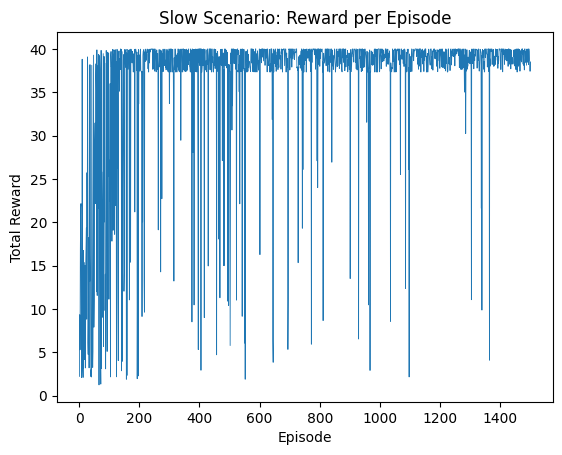

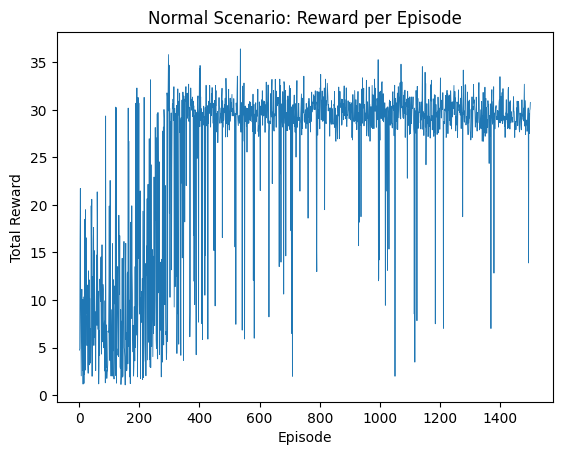

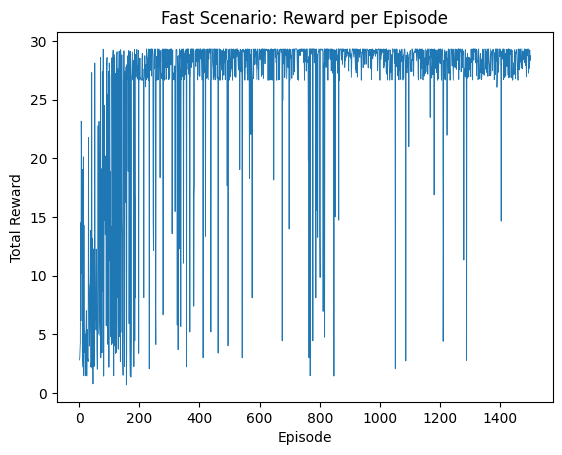

In [20]:
training_rewards = episode_dict

for scenario, rewards in training_rewards.items():
    plt.figure()
    plt.plot(range(1, len(rewards) + 1), rewards, linewidth=0.6)
    plt.title(f"{scenario} Scenario: Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

In [23]:
import os, numpy as np

output_dir = 'saved_models'
os.makedirs(output_dir, exist_ok=True)

for label, (env, q_model) in trained.items():
    # give it a .keras extension:
    model_path   = os.path.join(output_dir, f'{label}_q_model.keras')
    q_model.save(model_path)  
    print(f"Saved Keras model to: {model_path}")


Saved Keras model to: saved_models/Slow_q_model.keras
Saved Keras model to: saved_models/Normal_q_model.keras
Saved Keras model to: saved_models/Fast_q_model.keras


In [24]:
import numpy as np

# Convert each list to a NumPy array
arrays = {k: np.array(v) for k, v in episode_dict.items()}

# Save them all in one compressed .npz file
np.savez_compressed('episode_rewards.npz', **arrays)

print("Saved episode rewards to episode_rewards.npz")

Saved episode rewards to episode_rewards.npz


In [25]:
# data = np.load('episode_rewards.npz')
# slow_rewards   = data['Slow']   # as a NumPy array
# normal_rewards = data['Normal']
# fast_rewards   = data['Fast']